In [101]:
import pandas as pd
import os
import sys

import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

# Fitting an ARIMA process 

- load a time series
- acf, pacf
- order of MA or AR

- fit a ARIMA process with statsmodels
- calculer l'estiméé
- regarder les résidus
- metric: MSE, MAPE




In [38]:

# url = "https://raw.githubusercontent.com/alexisperrier/emines_ts/master/data/Historical%20Hourly%20Weather%20Data%202012-2017/temperature.csv"
url = "https://raw.githubusercontent.com/alexisperrier/emines_ts/master/data/otexts/a10.csv"
df = pd.read_csv(url)


In [39]:
df

,index,value
0,1991 Jul,3.526591
1,1991 Aug,3.180891
2,1991 Sep,3.252221
3,1991 Oct,3.611003
4,1991 Nov,3.565869
...,...,...
199,2008 Feb,21.654285
200,2008 Mar,18.264945
201,2008 Apr,23.107677
202,2008 May,22.912510


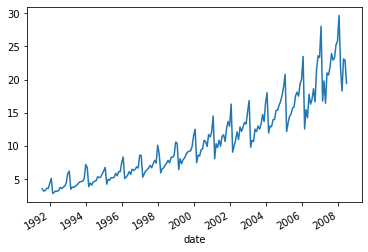

In [40]:
from dateutil import parser

df['date'] = df['index'].apply(lambda d : parser.parse(d))
# df['datetime'] = df['datetime'].apply(lambda d : parser.parse(d))

ts = pd.Series(data = df.value.values, index = df['date'])
# ts = pd.Series(data = df.Boston.values, index = df['datetime'])
ts = ts[~ts.isna()]
ts
ts.plot()

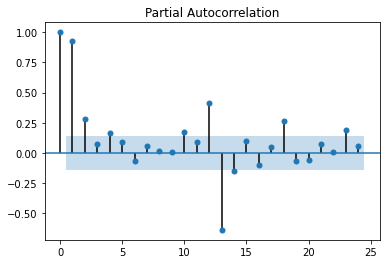

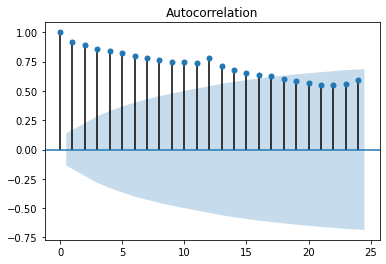

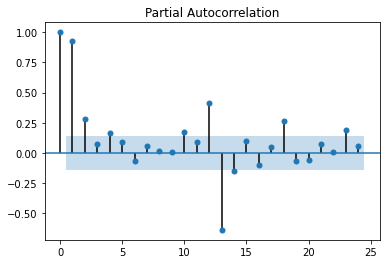

In [41]:
# import statsmodels.tsa.api as smt
smt.graphics.plot_acf(ts.values)
smt.graphics.plot_pacf(ts.values)


In [43]:
est_order = smt.AR(ts.values).select_order(maxlag=20, ic='aic', trend='c')
est_order


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2099: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianIn

8

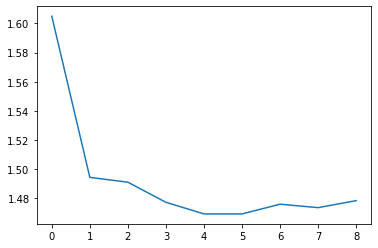

In [62]:
score = []
for i in range(1,10):
    mdl = smt.AR(ts.values).fit(maxlag=i, ic='aic', trend='c')
    # plt.plot(mdl.params)
    score.append(mdl.aic)
plt.plot(score)

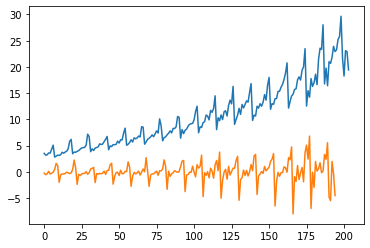

In [66]:
plt.plot(ts.values)
plt.plot(mdl.resid)

# modelisation AR sur la difference


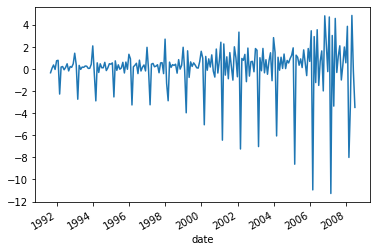

In [69]:
d = ts.diff()
d = d[~d.isna()]

d.plot()


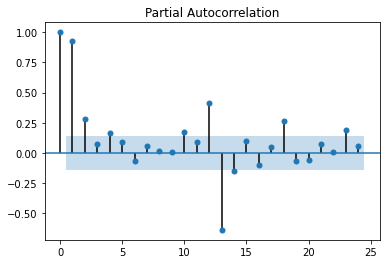

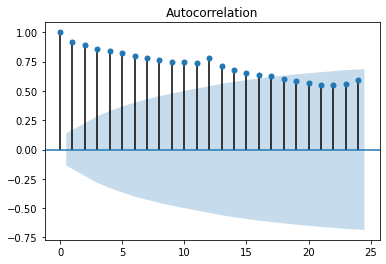

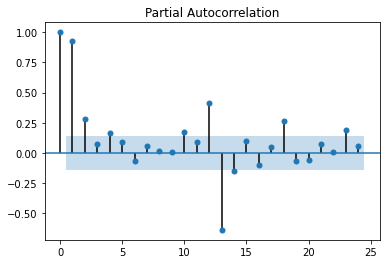

In [110]:
smt.graphics.plot_acf(ts.values)
smt.graphics.plot_pacf(ts.values)


In [108]:
score_bic = []
score_mse = []
for i in range(1,30):
    mdl = smt.AR(ts.values).fit(maxlag=i, ic='bic', trend='c')
    score_bic.append(mdl.bic)
    n_fitted = len(mdl.fittedvalues)
    score_mse.append( mse( mdl.fittedvalues, d.values[:n_fitted]  ))  


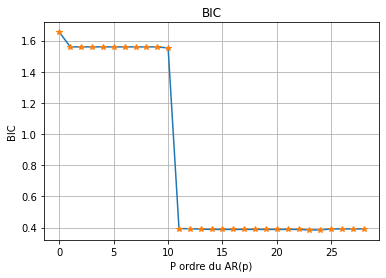

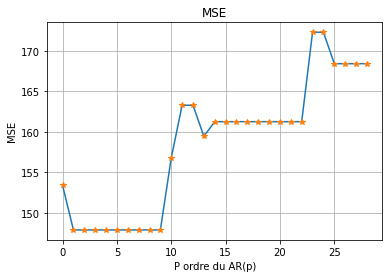

In [109]:
fig, ax = plt.subplots(1,1)
plt.title("BIC")
plt.xlabel("P ordre du AR(p)")
plt.ylabel("BIC")
plt.plot(score_bic)
plt.plot(score_bic, '*')
plt.grid()

fig, ax = plt.subplots(1,1)
plt.title("MSE")
plt.xlabel("P ordre du AR(p)")
plt.ylabel("MSE")
plt.plot(score_mse)
plt.plot(score_mse, '*')
plt.grid()

In [113]:
mdl = smt.AR(d.values).fit(maxlag=11, ic='bic', trend='c')

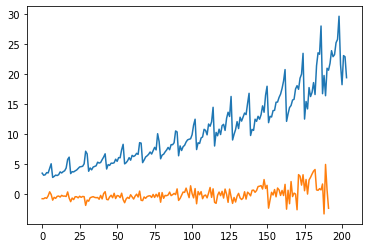

In [114]:
plt.plot(ts.values)
plt.plot(mdl.resid)

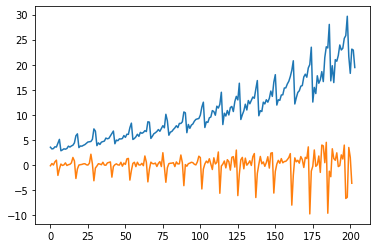

In [115]:
mdl = smt.AR(d.values).fit(maxlag=2, ic='bic', trend='c')
plt.plot(ts.values)
plt.plot(mdl.resid)


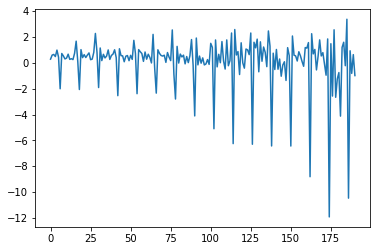

In [95]:
plt.plot(mdl.fittedvalues)
plt.plot(d.values)

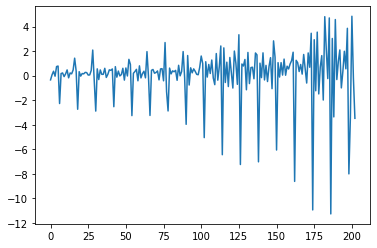

In [100]:
mse(d.values[:191], mdl.fittedvalues)

0.6220582094212863

In [119]:
print(mdl.summary())

NotImplementedError: ignored

# ARIMA - grid search



In [120]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        y.hist(bins = 20, ax = pp_ax)
        # scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()

In [121]:

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ts.values, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


NameError: ignored

aic: 820.34412 | order: (4, 1, 3)


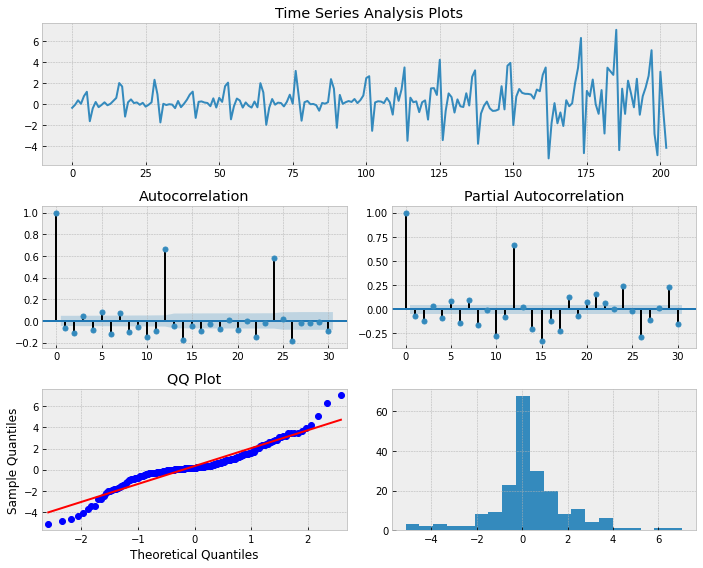

In [122]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)